In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thezaza102/tray-food-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 48% 9.00M/18.7M [00:00<00:00, 14.9MB/s]
100% 18.7M/18.7M [00:00<00:00, 27.1MB/s]


In [4]:
#unzipping file
!unzip tray-food-segmentation.zip

Archive:  tray-food-segmentation.zip
  inflating: TrayDataset/TrayDataset/XTest/1005a.jpg  
  inflating: TrayDataset/TrayDataset/XTest/2002a.jpg  
  inflating: TrayDataset/TrayDataset/XTest/3004a.jpg  
  inflating: TrayDataset/TrayDataset/XTest/4003a.jpg  
  inflating: TrayDataset/TrayDataset/XTest/5006a.jpg  
  inflating: TrayDataset/TrayDataset/XTest/6004a.jpg  
  inflating: TrayDataset/TrayDataset/XTest/7010a.jpg  
  inflating: TrayDataset/TrayDataset/XTest/8006a.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a01.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a02.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a03.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a04.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a05.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a06.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a07.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a08.jpg  
  inflating: TrayDataset/TrayDataset/XTrain/1001a09.jpg  
 

In [5]:
image_path = sorted(os.listdir("/content/TrayDataset/TrayDataset/XTrain"))
label_path = sorted(os.listdir("/content/TrayDataset/TrayDataset/yTrain"))

In [6]:
def load_images(inputdir, inputpath, imagesize):
    imglist = []
    
    for i in range(len(inputpath)):
        img = cv2.imread(inputdir+inputpath[i], cv2.IMREAD_COLOR) 
        img = cv2.resize(img, (imagesize, imagesize), interpolation = cv2.INTER_AREA)
        img = img[::-1] 
        imglist.append(img)
        
    return imglist

In [7]:
def segment(label, img_size):
    labels = []
    
    for i in range(len(label)):
        tmp = label[i].flatten()
        for j in range(len(tmp)):
            if tmp[j] > 10:
                tmp[j] = 200
                
        labels.append(tmp.reshape(img_size,img_size,3))
        
    return labels

In [8]:
IMAGE_SIZE = 128

image = load_images("/content/TrayDataset/TrayDataset/XTrain/", image_path,IMAGE_SIZE)

before_label = load_images("/content/TrayDataset/TrayDataset/yTrain/", label_path, IMAGE_SIZE)

after_label = segment(before_label, IMAGE_SIZE)

image /= np.max(image)
after_label /= np.max(after_label)

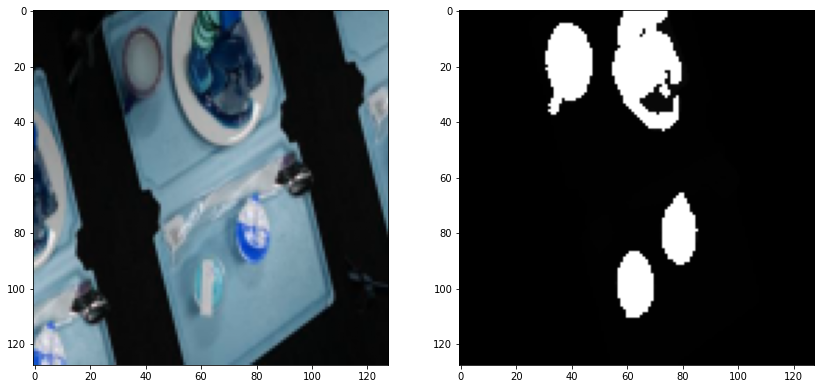

In [9]:
num = 50

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image[num]))

ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(after_label[num]))

In [10]:
def Unet():
    input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    enc1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(input_img)
    enc1 = BatchNormalization()(enc1)
    enc1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(enc1)
    enc1 = BatchNormalization()(enc1)
    down1 = MaxPooling2D(pool_size=2, strides=2)(enc1)
    
    enc2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(down1)
    enc2 = BatchNormalization()(enc2)
    enc2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(enc2)
    enc2 = BatchNormalization()(enc2)
    down2 = MaxPooling2D(pool_size=2, strides=2)(enc2)

    enc3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(down2)
    enc3 = BatchNormalization()(enc3)
    enc3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(enc3)
    enc3 = BatchNormalization()(enc3)
    down3 = MaxPooling2D(pool_size=2, strides=2)(enc3)
    
    enc4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(down3)
    enc4 = BatchNormalization()(enc4)
    enc4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(enc4)
    enc4 = BatchNormalization()(enc4)
    down4 = MaxPooling2D(pool_size=2, strides=2)(enc4)
    
    enc5 = Conv2D(2048, kernel_size=3, strides=1, activation="relu", padding="same")(down4)
    enc5 = BatchNormalization()(enc5)
    enc5 = Conv2D(2048, kernel_size=3, strides=1, activation="relu", padding="same")(enc5)
    enc5 = BatchNormalization()(enc5)

    up4 = UpSampling2D(size=2)(enc5)
    dec4 = concatenate([up4, enc4], axis=-1)
    dec4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(dec4)
    dec4 = BatchNormalization()(dec4)
    dec4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(dec4)
    dec4 = BatchNormalization()(dec4)
    
    up3 = UpSampling2D(size=2)(dec4)
    dec3 = concatenate([up3, enc3], axis=-1)
    dec3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(dec3)
    dec3 = BatchNormalization()(dec3)
    dec3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(dec3)
    dec3 = BatchNormalization()(dec3)

    up2 = UpSampling2D(size=2)(dec3)
    dec2 = concatenate([up2, enc2], axis=-1)
    dec2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(dec2)
    dec2 = BatchNormalization()(dec2)
    dec2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(dec2)
    dec2 = BatchNormalization()(dec2)
    
    up1 = UpSampling2D(size=2)(dec2)
    dec1 = concatenate([up1, enc1], axis=-1)
    dec1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(dec1)
    dec1 = BatchNormalization()(dec1)
    dec1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(dec1)
    dec1 = BatchNormalization()(dec1)
    
    dec1 = Conv2D(3, kernel_size=1, strides=1, activation="sigmoid", padding="same")(dec1)
    
    model = Model(input_img, dec1)
    
    return model

In [11]:
model = Unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  512        ['conv2d[0][0]']                 
 alization)                     8)                                                            

In [12]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [13]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [14]:
X_train, X_val, T_train, T_val = train_test_split(image, after_label, test_size=0.2)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[dice_coef])

initial_learningrate=2e-3

def lr_decay(epoch):
    if epoch < 10:
        return initial_learningrate
    else:
        return initial_learningrate * 0.99 ** epoch
    
training = model.fit(X_train, T_train,epochs=30, batch_size=12, shuffle=True, validation_data=(X_val, T_val), verbose=1,callbacks=[LearningRateScheduler(lr_decay,verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.002.
Epoch 1/30
83/83 [==============================] - 100s 954ms/step - loss: 0.3589 - dice_coef: 0.3999 - val_loss: 526.8870 - val_dice_coef: 0.1808 - lr: 0.0020

Epoch 2: LearningRateScheduler setting learning rate to 0.002.
Epoch 2/30
83/83 [==============================] - 58s 702ms/step - loss: 0.1653 - dice_coef: 0.5371 - val_loss: 1.0354 - val_dice_coef: 0.2651 - lr: 0.0020

Epoch 3: LearningRateScheduler setting learning rate to 0.002.
Epoch 3/30
83/83 [==============================] - 60s 724ms/step - loss: 0.1012 - dice_coef: 0.7027 - val_loss: 0.2952 - val_dice_coef: 0.1967 - lr: 0.0020

Epoch 4: LearningRateScheduler setting learning rate to 0.002.
Epoch 4/30
83/83 [==============================] - 60s 722ms/step - loss: 0.0742 - dice_coef: 0.7880 - val_loss: 0.3476 - val_dice_coef: 0.2322 - lr: 0.0020

Epoch 5: LearningRateScheduler setting learning rate to 0.002.
Epoch 5/30
83/83 [===========================

In [15]:
model.save("best_model.h5")

In [16]:
test_path = os.listdir("/content/TrayDataset/TrayDataset/XTest/")
test_image = load_images("/content/TrayDataset/TrayDataset/XTest/", test_path, IMAGE_SIZE)

test_image /= np.max(test_image)

In [17]:
results = model.predict(test_image,verbose=1)

1/1 [==============================] - 7s 7s/step


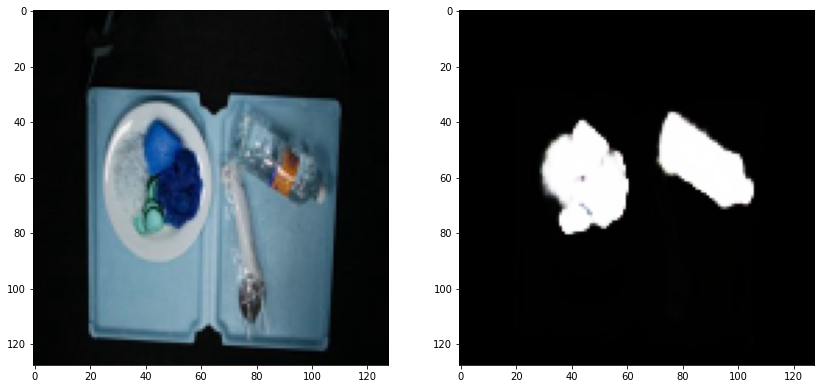

In [18]:
n = 7

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_image[n]))

ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(results[n]))

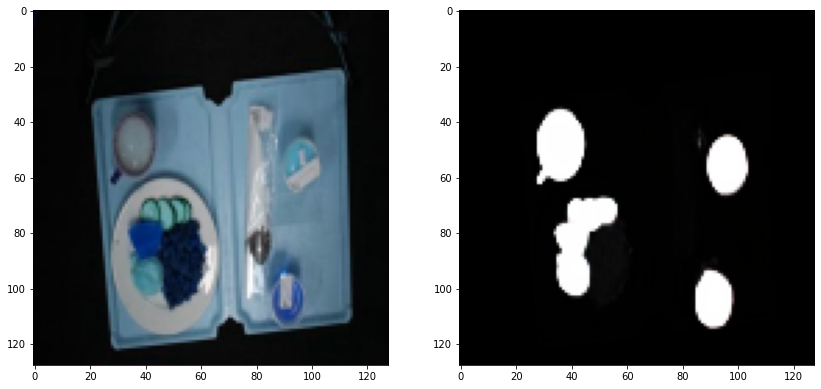

In [20]:
n = 5

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_image[n]))

ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(results[n]))